In [1]:
import matplotlib.pyplot as plt
from wavebench.dataloaders.rtc_loader import get_dataloaders_rtc_thick_lines, get_dataloaders_rtc_mnist
from wavebench.dataloaders.is_loader import get_dataloaders_is_thick_lines, get_dataloaders_is_mnist
from wavebench import wavebench_figure_path

import wandb
from wavebench.nn.pl_model_wrapper import LitModel
from pathlib import Path
from wavebench import wavebench_checkpoint_path
from wavebench.plot_utils import plot_images, remove_frame

from pytorch_lightning.loggers import WandbLogger
import ml_collections
import torch
import pprint


# Initialize the W&B API client
api = wandb.Api()


pp = pprint.PrettyPrinter(depth=6)
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

eval_config = ml_collections.ConfigDict()


# problem setting: can be 'is' or 'rtc'
# eval_config.problem = 'rtc'
eval_config.problem = 'is'

# dataset setting: can be 'thick_lines' or 'mnist'
# eval_config.dataset_name = 'mnist'
eval_config.dataset_name = 'thick_lines'

# medium_type setting: can be 'gaussian_lens' or 'gaussian_random_field'
eval_config.medium_type = 'gaussian_lens'
# eval_config.medium_type = 'gaussian_random_field'


if eval_config.problem == 'rtc' and eval_config.dataset_name == 'thick_lines':
  test_loader = get_dataloaders_rtc_thick_lines(
    medium_type=eval_config.medium_type,
  )['test']
elif eval_config.problem == 'rtc' and eval_config.dataset_name == 'mnist':
  test_loader = get_dataloaders_rtc_mnist(
    medium_type=eval_config.medium_type,
  )
elif eval_config.problem == 'is' and eval_config.dataset_name == 'thick_lines':
  test_loader = get_dataloaders_is_thick_lines(
    medium_type=eval_config.medium_type,
  )['test']
elif eval_config.problem == 'is' and eval_config.dataset_name == 'mnist':
  test_loader = get_dataloaders_is_mnist(
    medium_type=eval_config.medium_type)


### Visualize dataset

Text(0.5, 1.0, 'Target')

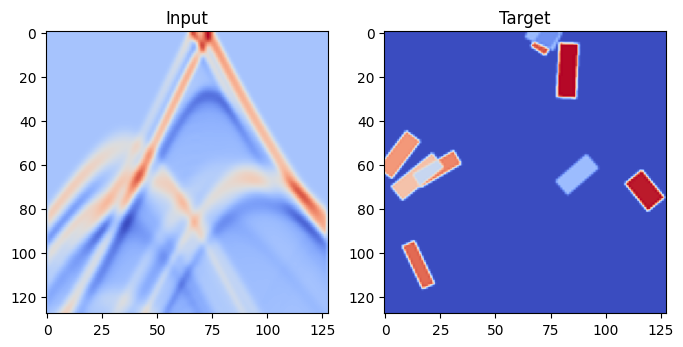

In [2]:
idx = 1
sample_input, sample_target = test_loader.dataset.__getitem__(idx)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(sample_input.squeeze().numpy(), cmap='coolwarm')
axes[0].set_title('Input')
axes[1].imshow(sample_target.squeeze().numpy(), cmap='coolwarm')
axes[1].set_title('Target')
# axes[2].imshow(pred.squeeze().numpy(), cmap='coolwarm')
# axes[2].set_title('Prediction')
# rtc_loaders[medium_type] = loaders

### Load relevant models

In [3]:

all_models = [
  # {
  #   "tag": 'fno-depth-4',
  #   "config.model_config/model_name": 'fno',
  #   "config.model_config/num_hidden_layers": 4
  # },
  {
    "tag": 'fno-depth-8',
    "config.model_config/model_name": 'fno',
    "config.model_config/num_hidden_layers": 8
  },
  # {
  #   "tag": 'unet-ch-32',
  #   "config.model_config/model_name": 'unet',
  #   "config.model_config/channel_reduction_factor": 2
  # },
  {
    "tag": 'unet-ch-64',
    "config.model_config/model_name": 'unet',
    "config.model_config/channel_reduction_factor": 1
  },

              ]




In [4]:
model_dict = {}

for model_filters in all_models:
  _model_filters = model_filters.copy()

  model_tag = _model_filters.pop('tag')

  # model_filters = {
  #   "config.model_config/model_name": 'unet',
  #   "config.model_config/channel_reduction_factor": 2}

  # model_filters = {
  #   "tag": 'fno_depth_8',
  #   "config.model_config/model_name": 'fno',
  #   "config.model_config/num_hidden_layers": 8}

  project = f'{eval_config.problem}_{eval_config.medium_type}'
  runs = api.runs(
    path=f"tliu/{project}",
    filters=_model_filters)

  # make sure that there is a unique model that satisfies the filters
  assert len(runs) == 1

  run_id = runs[0].id

  checkpoint_reference = f"tliu/{project}/model-{run_id}:best"#best"
  print(f'checkpoint: {checkpoint_reference}')

  artifact_dir = WandbLogger.download_artifact(
    artifact=checkpoint_reference,
    save_dir=wavebench_checkpoint_path)

  # load checkpoint
  model = LitModel.load_from_checkpoint(
    Path(artifact_dir) / "model.ckpt").to(device)

  print('model hparams:')
  pp.pprint(model.hparams.model_config)

  model_dict[model_tag] = model
  # runs = api.runs(path="tliu/rtc_gaussian_lens")

checkpoint: tliu/is_gaussian_lens/model-a4iag3p1:best


wandb: Downloading large artifact model-a4iag3p1:best, 384.63MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.0


model hparams:
{'hidden_width': 64,
 'model_name': 'fno',
 'modes1': 16,
 'modes2': 16,
 'num_hidden_layers': 8,
 'num_in_channels': 1,
 'num_out_channels': 1}
checkpoint: tliu/is_gaussian_lens/model-45utolzm:best


wandb: Downloading large artifact model-45utolzm:best, 355.33MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.0


model hparams:
{'channel_reduction_factor': 1,
 'model_name': 'unet',
 'n_input_channels': 1,
 'n_output_channels': 1}


In [5]:
idx = 1
sample_input, sample_target = test_loader.dataset.__getitem__(idx)

# for model in model_dict:

pred_dict = {
  'input': sample_input.squeeze(),
  'gt': sample_target.squeeze()}
# pred_dict = {}
for tag, model in model_dict.items():
  pred = model(sample_input.unsqueeze(0).to(device)).detach().cpu().squeeze()
  pred_dict[tag] = pred


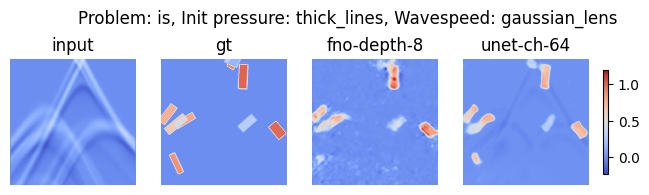

In [16]:


fig, axes = plot_images(
  list(pred_dict.values()),
  cbar='one',
  fig_size=(9, 9),
  shrink=0.15,
  pad=0.02,
  cmap='coolwarm')

# axes[0,0]
for i, ax in enumerate(axes.flatten()):
  ax.set_title( list(pred_dict.keys()) [i])
  remove_frame(ax) #for ax in axes.flatten()]

plt.suptitle(
  f'Problem: {eval_config.problem}, Init pressure: {eval_config.dataset_name}, Wavespeed: {eval_config.medium_type}',
  y=0.62,)

plt.savefig(
  f"{wavebench_figure_path}/model_out_{eval_config.problem}_{eval_config.dataset_name}_{eval_config.medium_type}.pdf",
  format="pdf", bbox_inches="tight")


In [7]:


# fig, axes = plt.subplots(1, len(pred_dict), figsize=(len(pred_dict) * 4, 4))

# axes[0].imshow(sample_input.squeeze().numpy(), cmap='coolwarm')
# axes[0].set_title('Input')
# axes[1].imshow(sample_target.squeeze().numpy(), cmap='coolwarm')
# axes[1].set_title('Target')
# axes[2].imshow(pred.squeeze().numpy(), cmap='coolwarm')
# axes[2].set_title('Prediction')

# # rtc_loaders[medium_type] = loaders

In [18]:
import numpy as np

a = np.array([[1, 2], [3, 4]])

np.pad(a, 3, 'constant', constant_values=0)

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 2, 0, 0, 0],
       [0, 0, 0, 3, 4, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]])